In [1]:
import glob, os, random, zipfile, yaml
import numpy as np
import pandas as pd
from collections import defaultdict
import pysam
import matplotlib.pyplot as plt

with open("config.yaml") as f:
    samples = yaml.load(f, Loader=yaml.BaseLoader)["samples"]

# Report Base quality and GC content

In [2]:
array = []
for path in sorted(glob.glob("results/prepare/fastqc/*_fastqc.zip")):
    sample = path.split("/")[-1].strip("_fastqc.zip")[:-3]  # _R1 or _R2
    if sample not in samples:
        continue
    with zipfile.ZipFile(path, "r") as f:
        for name in f.namelist():
            if not name.endswith("/fastqc_data.txt"):
                continue
            with f.open(name) as h:
                lines = []
                for line in h:
                    line = line.decode("utf-8")
                    lines.append(line.strip("\n"))

                d1 = dict()
                for i, line in enumerate(lines):
                    if line.startswith(">>Per sequence quality scores"):
                        j = i + 2
                        while j < len(lines):
                            line1 = lines[j]
                            if line1 == ">>END_MODULE":
                                break
                            qua, count = line1.split("\t")
                            d1[int(qua)] = float(count)
                            j += 1
                        break

                d2 = dict()
                for i, line in enumerate(lines):
                    if line.startswith(">>Per sequence GC content"):
                        j = i + 2
                        while j < len(lines):
                            line1 = lines[j]
                            if line1 == ">>END_MODULE":
                                break
                            gc, count = line1.split("\t")
                            d2[int(gc)] = float(count)
                            j += 1
                        break
                array.append([d1, d2])

In [3]:
total = 0
count = 0
for d1, d2 in array:
    for qua, c in d1.items():
        total += c
        if qua >= 30:
            count += c
ratio = count / total
print("Total reads: ", total)
print("Reads with average base quality >= 30:", ratio)

Total reads:  6850935558.0
Reads with average base quality >= 30: 0.9726263684116819


In [9]:
d = defaultdict(int)
for d1, d2 in array:
    for qua, c in d1.items():
        d[qua] += c
xs = []
ys = []
for x in sorted(d.keys()):
    xs.append(x)
    ys.append(d[x])
ys = np.array(ys)
ys = ys * 100 / sum(ys)

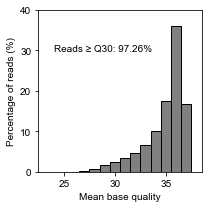

In [30]:
plt.figure(figsize=(3, 3))
plt.bar(xs, ys, color="grey", edgecolor="black", lw=1, width=1)
plt.text(24, 30, "Reads ≥ Q30: %.2f%%" % (ratio * 100))
plt.xlabel("Mean base quality")
plt.ylabel("Percentage of reads (%)")
plt.yticks([0, 10, 20, 30, 40])
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, 40)
plt.tight_layout()
plt.savefig("figures/Mean_base_quality.bar.png", dpi=300)

In [31]:
xs = np.arange(0, 101)
ys = np.zeros(101)
for d1, d2 in array:
    for k, v in d2.items():
        ys[k] += v

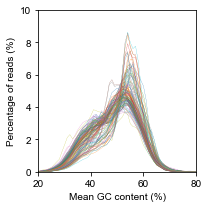

In [37]:
plt.figure(figsize=(3, 3))
for d1, d2 in array:
    xs = np.arange(0, 101)
    ys = np.zeros(101)
    for k, v in d2.items():
        ys[k] += v
    ys = ys * 100 / sum(ys)
    plt.plot(xs, ys, lw=0.2)
plt.xlabel("Mean GC content (%)")
plt.ylabel("Percentage of reads (%)")
plt.xlim(20, 80)
plt.ylim(0, 10)
plt.tight_layout()
plt.show()

# Report STAR log (1st round)

In [2]:
array = []
for path in sorted(glob.glob("results/mapping/star/mapped.1st/*/Log.final.out")):
    sample = path.split("/")[-2]
    names = []
    values = []
    with open(path) as f:
        for line in f:
            if "|" not in line:
                continue
            name, value = line.strip("\n").split("|")
            names.append(name.strip())
            values.append(value.strip())
    s = pd.Series(values, index=names)
    s.name = sample
    array.append(s)
dat = pd.DataFrame(array)
dat.index.name = "Sample"
dat.to_csv("results/mapping/star/mapped.1st_all_log.tsv", sep="\t")
dat.head()

,Started job on,Started mapping on,Finished on,"Mapping speed, Million of reads per hour",Number of input reads,Average input read length,Uniquely mapped reads number,Uniquely mapped reads %,Average mapped length,Number of splices: Total,...,Number of reads mapped to too many loci,% of reads mapped to too many loci,Number of reads unmapped: too many mismatches,% of reads unmapped: too many mismatches,Number of reads unmapped: too short,% of reads unmapped: too short,Number of reads unmapped: other,% of reads unmapped: other,Number of chimeric reads,% of chimeric reads
Sample,,,,,,,,,,,,,,,,,,,,,
Ad_Br_Fe_3,Dec 28 19:01:17,Dec 28 19:01:17,Dec 28 19:16:34,161.32,41090797,300,33769712,82.18%,297.15,24978160,...,7135,0.02%,0,0.00%,1015625,2.47%,6142,0.01%,0,0.00%
Ad_Br_Fe_4,Dec 28 18:57:20,Dec 28 18:57:20,Dec 28 19:13:31,152.13,41033467,300,35779477,87.20%,297.07,27702158,...,10939,0.03%,0,0.00%,995885,2.43%,6998,0.02%,0,0.00%
Ad_Br_Ma_2,Dec 28 17:19:14,Dec 28 17:19:14,Dec 28 17:34:22,204.26,51519111,300,47720978,92.63%,298.38,32666228,...,8509,0.02%,0,0.00%,627182,1.22%,8024,0.02%,0,0.00%
Ad_Br_Ma_4,Dec 28 19:11:16,Dec 28 19:11:16,Dec 28 19:23:17,204.05,40865882,300,35844684,87.71%,297.14,28420814,...,9297,0.02%,0,0.00%,1148146,2.81%,7337,0.02%,0,0.00%
Ad_Ey_Fe_3,Dec 28 19:08:56,Dec 28 19:08:56,Dec 28 19:22:01,185.20,40383580,300,35513978,87.94%,297.14,28303545,...,9018,0.02%,0,0.00%,901501,2.23%,5974,0.01%,0,0.00%


# Report STAR log (2nd round)

In [3]:
array = []
for path in sorted(glob.glob("results/mapping/star/mapped.2nd/*/Log.final.out")):
    sample = path.split("/")[-2]
    names = []
    values = []
    with open(path) as f:
        for line in f:
            if "|" not in line:
                continue
            name, value = line.strip("\n").split("|")
            names.append(name.strip())
            values.append(value.strip())
    s = pd.Series(values, index=names)
    s.name = sample
    array.append(s)
dat = pd.DataFrame(array)
dat.index.name = "Sample"
dat.to_csv("results/mapping/star/mapped.2nd_all_log.tsv", sep="\t")
dat.head()

,Started job on,Started mapping on,Finished on,"Mapping speed, Million of reads per hour",Number of input reads,Average input read length,Uniquely mapped reads number,Uniquely mapped reads %,Average mapped length,Number of splices: Total,...,Number of reads mapped to too many loci,% of reads mapped to too many loci,Number of reads unmapped: too many mismatches,% of reads unmapped: too many mismatches,Number of reads unmapped: too short,% of reads unmapped: too short,Number of reads unmapped: other,% of reads unmapped: other,Number of chimeric reads,% of chimeric reads
Sample,,,,,,,,,,,,,,,,,,,,,
Ad_Br_Fe_3,Mar 05 22:15:32,Mar 05 22:23:25,Mar 05 23:09:25,53.60,41090797,300,33682826,81.97%,297.91,28679097,...,6464562,15.73%,0,0.00%,916163,2.23%,27246,0.07%,0,0.00%
Ad_Br_Fe_4,Mar 05 22:12:25,Mar 05 22:23:32,Mar 05 23:07:43,55.72,41033467,300,35643697,86.86%,297.89,31758179,...,4458486,10.87%,0,0.00%,896952,2.19%,34332,0.08%,0,0.00%
Ad_Br_Ma_2,Mar 05 08:53:53,Mar 05 09:05:12,Mar 05 09:49:19,70.07,51519111,300,47500459,92.20%,298.90,36875922,...,3406613,6.61%,0,0.00%,580065,1.13%,31974,0.06%,0,0.00%
Ad_Br_Ma_4,Mar 05 23:31:08,Mar 05 23:49:16,Mar 06 00:20:29,78.55,40865882,300,35730667,87.43%,297.90,32427505,...,4060728,9.94%,0,0.00%,1040555,2.55%,33932,0.08%,0,0.00%
Ad_Ey_Fe_3,Mar 05 23:07:47,Mar 05 23:32:18,Mar 06 00:04:24,75.48,40383580,300,35338936,87.51%,297.99,32379257,...,4195184,10.39%,0,0.00%,817975,2.03%,31485,0.08%,0,0.00%


# Summary of read numbers

In [7]:
dat = pd.read_csv("results/mapping/star/mapped.2nd_all_log.tsv", sep="\t", index_col=0)
total = np.sum(dat["Number of input reads"])
mean = np.mean(dat["Number of input reads"])
std = np.std(dat["Number of input reads"])
print("Total reads:", total, sep="\t")
print("Mean reads:", mean, sep="\t")
print("Std:", std, sep="\t")

Total reads:	3425467779
Mean reads:	51901026.95454545
Std:	6336743.142834108


# Summary of mapped ratio

Mean:	90.37939393939396	7.428181818181817	1.7907575757575758	0.40227272727272717
Std:	2.4439374779790084	2.3775164217444082	0.5446757980135751	0.7203050538691025


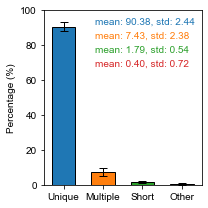

In [11]:
dat = pd.read_csv("results/mapping/star/mapped.2nd_all_log.tsv", sep="\t", index_col=0)
rows = []
for vs in dat[["Uniquely mapped reads %", 
               "% of reads mapped to too many loci", 
               "% of reads unmapped: too short", 
               "% of reads unmapped: other"]].values:
    rows.append([float(v[:-1]) for v in vs])
d = pd.DataFrame(rows)
ys = d.mean()
ye = d.std()
print("Mean:", *ys.values, sep="\t")
print("Std:", *ye.values, sep="\t")
xs = [0, 1, 2, 3]
xticks = ["Unique", "Multiple", "Short", "Other"]
colors = ["C0", "C1", "C2", "C3"]
plt.figure(figsize=(3, 3))
plt.bar(xs, ys, yerr=ye, width=0.6, 
        color=colors, lw=1, 
        edgecolor="black", 
        error_kw={"capsize": 4, "linewidth": 1, "capthick": 1})
for i, (mean, std, c) in enumerate(zip(ys, ye, colors)):
    plt.text(0.8, 100 - (i+1) * 8, "mean: %.2f, std: %.2f" % (mean, std), color=c)
plt.xlim(-0.5, 3.5)
plt.xticks(xs, xticks, rotation=0)
plt.ylim(0, 100)
plt.ylabel("Percentage (%)")
plt.tight_layout()
plt.savefig("figures/mapping.ratio.bar.png", dpi=300)

# Plot unique and multi mapped ratio (scatter)

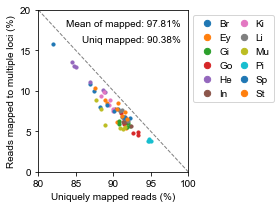

In [21]:
dat = pd.read_csv("results/mapping/star/mapped.2nd_all_log.tsv", sep="\t", index_col=0)

xs = [float(v[:-1]) for v in dat["Uniquely mapped reads %"]]
ys = [float(v[:-1]) for v in dat["% of reads mapped to too many loci"]]
zs = np.array(xs) + np.array(ys)
m = np.mean(zs)
mx = np.mean(xs)


tissues = list(sorted(set([v.split("_")[1] for v in dat.index])))
plt.figure(figsize=(4, 3))
for i, t in enumerate(tissues):
    tmp = dat[[v.split("_")[1] == t for v in dat.index]]
    xs = [float(v[:-1]) for v in tmp["Uniquely mapped reads %"]]
    ys = [float(v[:-1]) for v in tmp["% of reads mapped to too many loci"]]
    plt.scatter(xs, ys, s=10, color="C%d" % i, label=t)
plt.plot([80, 100], [20, 0], lw=1, color="grey", ls="--")
plt.xlim(80, 100)
plt.ylim(0, 20)   
plt.text(99, 18, "Mean of mapped: %.2f%%" % m, ha="right")
plt.text(99, 16, "Uniq mapped: %.2f%%" % mx, ha="right")
plt.yticks(np.arange(0, 21, 5))
plt.xlabel("Uniquely mapped reads (%)")
plt.ylabel("Reads mapped to multiple loci (%)")
plt.legend(ncol=2, bbox_to_anchor=(1, 1), loc="upper left", markerscale=2, 
           columnspacing=0.1, handletextpad=0.2, frameon=True)
plt.tight_layout()
plt.savefig("figures/stat.star.mapped.2nd.png", dpi=300)

# Summary of sequencing and mapping (table)

In [13]:
dat = pd.read_csv("results/mapping/star/mapped.2nd_all_log.tsv", sep="\t", index_col=0)
tissues = sorted(set([n.split("_")[1] for n in dat.index]))
rows = []
for t in tissues:
    row = [t]
    
    v1, v2, v3, v4 = 0, 0, 0, 0
    tmp = dat[[n.startswith("Ju_%s_Mi" % t) for n in dat.index]]
    if len(tmp) > 0:
        v1 = tmp.iloc[0]["Number of input reads"]
        v2 = tmp.iloc[0]["Uniquely mapped reads %"]
        v3 = tmp.iloc[1]["Number of input reads"]
        v4 = tmp.iloc[1]["Uniquely mapped reads %"]
    row.extend([v1, v2, v3, v4])
    
    v1, v2, v3, v4 = 0, 0, 0, 0
    tmp = dat[[n.startswith("Ad_%s_Fe" % t) for n in dat.index]]
    if len(tmp) > 0:
        v1 = tmp.iloc[0]["Number of input reads"]
        v2 = tmp.iloc[0]["Uniquely mapped reads %"]
        v3 = tmp.iloc[1]["Number of input reads"]
        v4 = tmp.iloc[1]["Uniquely mapped reads %"]
    row.extend([v1, v2, v3, v4])
    
    v1, v2, v3, v4 = 0, 0, 0, 0
    tmp = dat[[n.startswith("Ad_%s_Ma" % t) for n in dat.index]]
    if len(tmp) > 0:
        v1 = tmp.iloc[0]["Number of input reads"]
        v2 = tmp.iloc[0]["Uniquely mapped reads %"]
        v3 = tmp.iloc[1]["Number of input reads"]
        v4 = tmp.iloc[1]["Uniquely mapped reads %"]
    row.extend([v1, v2, v3, v4])
    
    rows.append(row)
d = pd.DataFrame(rows)
d.columns = ["Tissue", 
             "Ju_Mi_Rep1", "Ju_Mi_Rep1(%)", "Ju_Mi_Rep2", "Ju_Mi_Rep2(%)", 
             "Ad_Fe_Rep1", "Ad_Fe_Rep1(%)", "Ad_Fe_Rep2", "Ad_Fe_Rep2(%)",
             "Ad_Ma_Rep1", "Ad_Ma_Rep1(%)", "Ad_Ma_Rep2", "Ad_Ma_Rep2(%)"]
d.to_csv("results/mapping/star/mapped.2nd.table.tsv", sep="\t", index=False)
d.head()

,Tissue,Ju_Mi_Rep1,Ju_Mi_Rep1(%),Ju_Mi_Rep2,Ju_Mi_Rep2(%),Ad_Fe_Rep1,Ad_Fe_Rep1(%),Ad_Fe_Rep2,Ad_Fe_Rep2(%),Ad_Ma_Rep1,Ad_Ma_Rep1(%),Ad_Ma_Rep2,Ad_Ma_Rep2(%)
0,Br,50708476,88.20%,50701782,90.58%,41090797,81.97%,41033467,86.86%,51519111,92.20%,40865882,87.43%
1,Ey,50308846,90.51%,50341739,91.76%,40383580,87.51%,40451467,89.18%,51215267,90.58%,39023075,88.87%
2,Gi,50667828,91.93%,51135294,91.84%,61171646,90.72%,60827232,91.88%,48890128,90.79%,50258336,92.18%
3,Go,50442747,92.60%,50979610,93.33%,50176177,91.41%,50724918,91.06%,51277725,93.30%,40026759,91.43%
4,He,46854864,85.02%,50685703,84.70%,61591606,86.94%,60467968,84.54%,50867074,88.96%,50598194,88.65%


# Report MarkDuplicates log

In [14]:
array = []
for path in sorted(glob.glob("results/mapping/markdup/*_metrics.txt")):
    sample = path.split("/")[-1][:-len("_metrics.txt")]
    with open(path) as f:
        lines = f.readlines()
        s = None
        for i, line in enumerate(lines):
            if line.startswith("## METRICS"):
                names = lines[i + 1].strip("\n").split("\t")
                values = lines[i + 2].strip("\n").split("\t")
                s = pd.Series(values, index=names)
                s.name = sample
                array.append(s)
dat = pd.DataFrame(array)
dat.index.name = "Sample"
dat.to_csv("results/mapping/markdup_all_metrics.tsv", sep="\t")
dat.head()

,LIBRARY,UNPAIRED_READS_EXAMINED,READ_PAIRS_EXAMINED,SECONDARY_OR_SUPPLEMENTARY_RDS,UNMAPPED_READS,UNPAIRED_READ_DUPLICATES,READ_PAIR_DUPLICATES,READ_PAIR_OPTICAL_DUPLICATES,PERCENT_DUPLICATION,ESTIMATED_LIBRARY_SIZE
Sample,,,,,,,,,,
Ad_Br_Fe_3,Unknown Library,0,31932596,0,0,0,6537274,0,0.204721,66937090
Ad_Br_Fe_4,Unknown Library,0,34415967,0,0,0,7906539,0,0.229735,62928737
Ad_Br_Ma_2,Unknown Library,0,46681746,0,0,0,9813866,0,0.210229,94848751
Ad_Br_Ma_4,Unknown Library,0,34783109,0,0,0,8084426,0,0.232424,62717258
Ad_Ey_Fe_3,Unknown Library,0,34294462,0,0,0,8548242,0,0.24926,56810100


# Plot MarkDuplicates summary

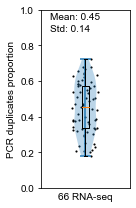

In [16]:
dat = pd.read_csv("results/mapping/markdup_all_metrics.tsv", sep="\t", index_col=0)
values = dat["PERCENT_DUPLICATION"]

plt.figure(figsize=(2, 3))
random.seed(1)
xs = [0.7 + random.random() * 0.6  for i in range(len(values))]
plt.scatter(xs, values, marker=".", color="black", s=5)
plt.violinplot(values)
plt.boxplot(values)
plt.text(0.2, 0.95, "Mean: %.2f" % np.mean(values))
plt.text(0.2, 0.88, "Std: %.2f" % np.std(values))
# plt.text(0.2, 0.81, "Median: %.2f" % np.median(values))

plt.ylabel("PCR duplicates proportion")
plt.xlabel("66 RNA-seq")
plt.xticks([])
# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)
# plt.gca().spines["bottom"].set_visible(False)
plt.ylim(0, 1)
plt.xlim(0, 2)
plt.tight_layout()
plt.savefig("figures/markdup.summary.png", dpi=300)

# Merge bams for IGV (only NW_019174257.1)

In [37]:
paths = [p for p in sorted(glob.glob("results/mapping/rmdup/*.bam"))]
chrom = "NW_019174257.1"

with pysam.AlignmentFile(paths[0]) as f:
    header = f.header.as_dict()
    rg_list = []
    for s in samples:
        rg = {"ID": s, "LB": s, "SM": s}
        rg_list.append(rg)
    header["RG"] = rg_list 

with pysam.AlignmentFile("results/all_samples.rmdup.NW_019174257.1.bam", "wb", header=header) as fw:
    for s, p in zip(samples, paths):
        with pysam.AlignmentFile(p) as f:
            for segment in f.fetch(contig=chrom):
                segment.set_tag("RG", s)
                fw.write(segment)

p1 = "results/all_samples.rmdup.NW_019174257.1.bam"
p2 = "results/all_samples.rmdup.NW_019174257.1.sorted.bam"
cmd = "samtools sort -o %s %s" % (p2, p1)
assert os.system(cmd) == 0
cmd = "samtools index %s" % p2
assert os.system(cmd) == 0
cmd = "rm %s" % p1
assert os.system(cmd) == 0